### Import Libraries

In [1]:
# import Libraries
%matplotlib inline
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from skimage.transform import resize

### Load Dataset, explore it, and split it into train, validation, and test sets

In [2]:
# Load .csv file
csv_file=pd.read_csv("fer2013.csv")
csv_file.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
# The data comes already split in 3 Usage categories "Training", "PrivateTest", and "PublicTest", which we would use as
# our Training, Validation, and Test sets respectively.

# Converting numbers of pixels and emotions to list
X_train,Y_train,X_val,Y_val,X_test,Y_test=[],[],[],[],[],[]

In [4]:
# Using for loop to continously take every pixels and emotions from .csv file that are in integer.
for index, row in csv_file.iterrows():
    # variable val will store value of pixels
    val=row['pixels'].split(" ")#split(" ") will give spaces between every pixels
    
    # Using try and except block to test if the given condition satisfies
    try:
        # if Training exists in column 'Usage' then append(i.e. add) variable val(i.e. pixels) and integer from column emotion
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           Y_train.append(row['emotion'])
        
        # if 'PrivateTest' exists in column Usage then append(i.e. add) variable val(i.e. pixels) and integer from column emotion
        elif 'PrivateTest' in row['Usage']:
            X_val.append(np.array(val,'float32'))
            Y_val.append(row['emotion'])

        # if the above conditions don't satisfy, then if 'PublicTest' exists in column Usage then append(i.e. add) variable val(i.e. pixels) and integer from column emotion
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           Y_test.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")

In [5]:
num_features = 64
num_labels = 7
width, height = 48, 48


X_train = np.array(X_train,'float32')
Y_train = np.array(Y_train,'float32')
X_val = np.array(X_val,'float32')
Y_val = np.array(Y_val,'float32')
X_test = np.array(X_test,'float32')
Y_test = np.array(Y_test,'float32')

Y_train=np_utils.to_categorical(Y_train, num_classes=num_labels)
Y_val=np_utils.to_categorical(Y_val, num_classes=num_labels)
Y_test=np_utils.to_categorical(Y_test, num_classes=num_labels)

### Data Scaling

In [6]:
# Data Normalization by Standardization

#normalizing data between 0 and 1 of X_train 
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

#normalizing data between 0 and 1 of X_val
X_val -= np.mean(X_val, axis=0)
X_val /= np.std(X_val, axis=0)

#normalizing data between 0 and 1 of X_test
X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)



#reshape the pixels of X_train, X_val, and X_test
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

### Data Inspection

In [7]:
#Number of samples across each set

print("Number of images in Training set:", len(X_train))
print("Number of images in Validation set:", len(X_val))
print("Number of images in Test set:", len(X_test))

Number of images in Training set: 28709
Number of images in Validation set: 3589
Number of images in Test set: 3589


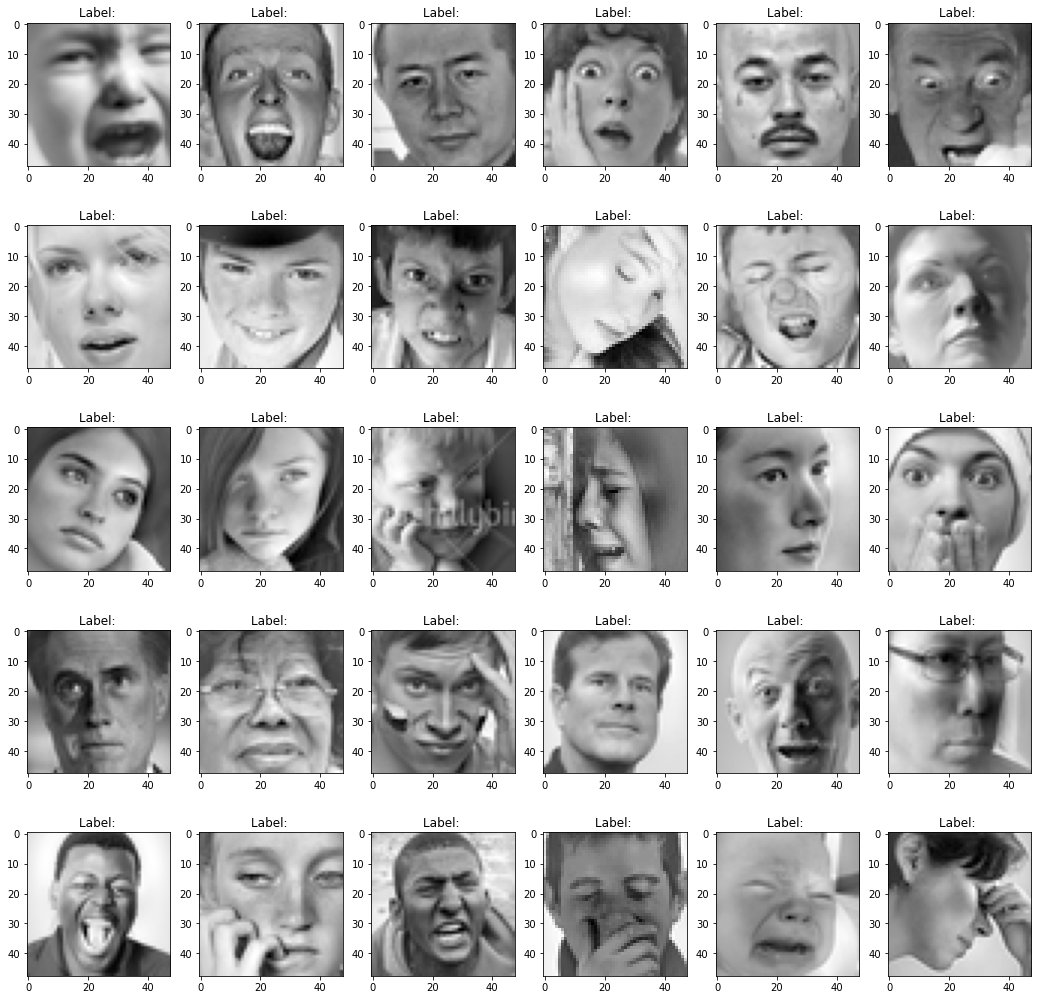

In [8]:
# Displaying some samples from the training set
sample_indexes = np.random.choice(np.arange(X_train.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (18,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_train[jj], cmap = "gray")
    plt.title("Label: " %Y_train[jj])
plt.show()

Text(0.5, 1.0, 'Counts per emotion in testing set')

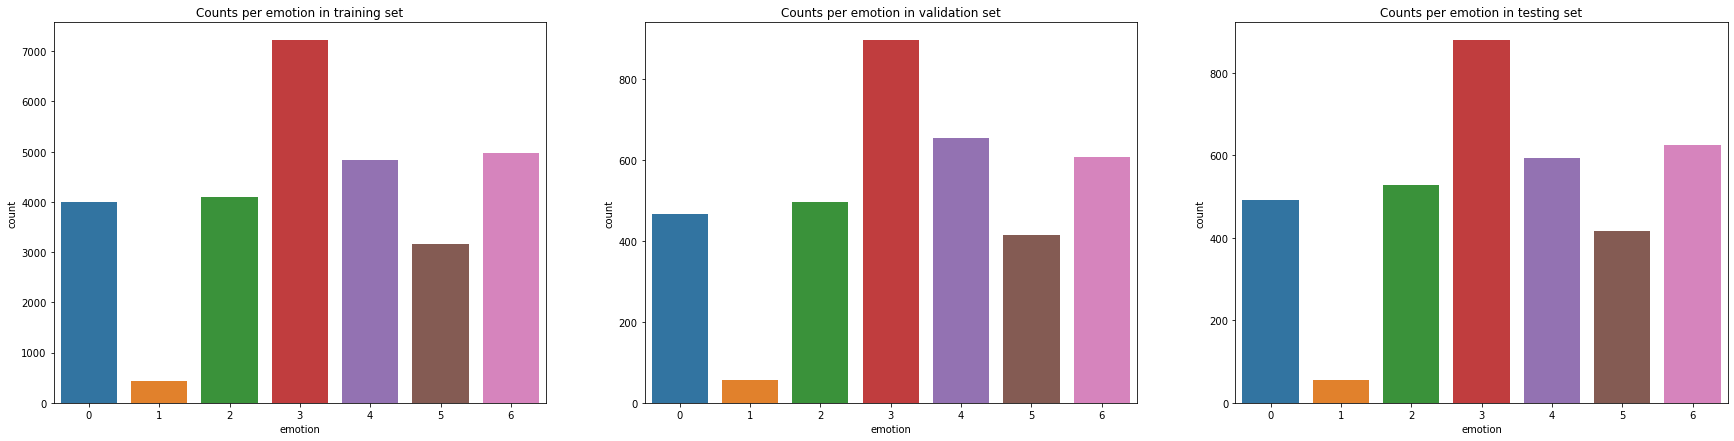

In [9]:
# Class Distribution among each sets

groups = [g for _, g in csv_file.groupby('Usage')]
train = groups[2]
val = groups[1]
test = groups[0]

train = train.drop(labels=['Usage'], axis=1)
val = val.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

Y_tr = train["emotion"]
Y_vl = val["emotion"]
Y_tst = test["emotion"]

# Emotions are: 0 = 'Angry', 1 = 'Disgust', 2 = 'Fear', 3 = 'Happy', 4 = 'Sad', 5 = 'Surprise', 6 = 'Neutral'

plt.figure(figsize=(30, 7))

plt.subplot(1,3,1)
ax = sns.countplot(x = Y_tr)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in training set")

plt.subplot(1,3,2)
ax = sns.countplot(x = Y_vl)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in validation set")

plt.subplot(1,3,3)
ax = sns.countplot(x = Y_tst)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in testing set")

### Model Definition

In [10]:
batch_size = 64
epochs = 100
learning_rate = 0.001

In [11]:
model = Sequential()
    
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
adam = tf.optimizers.Adam(learning_rate)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

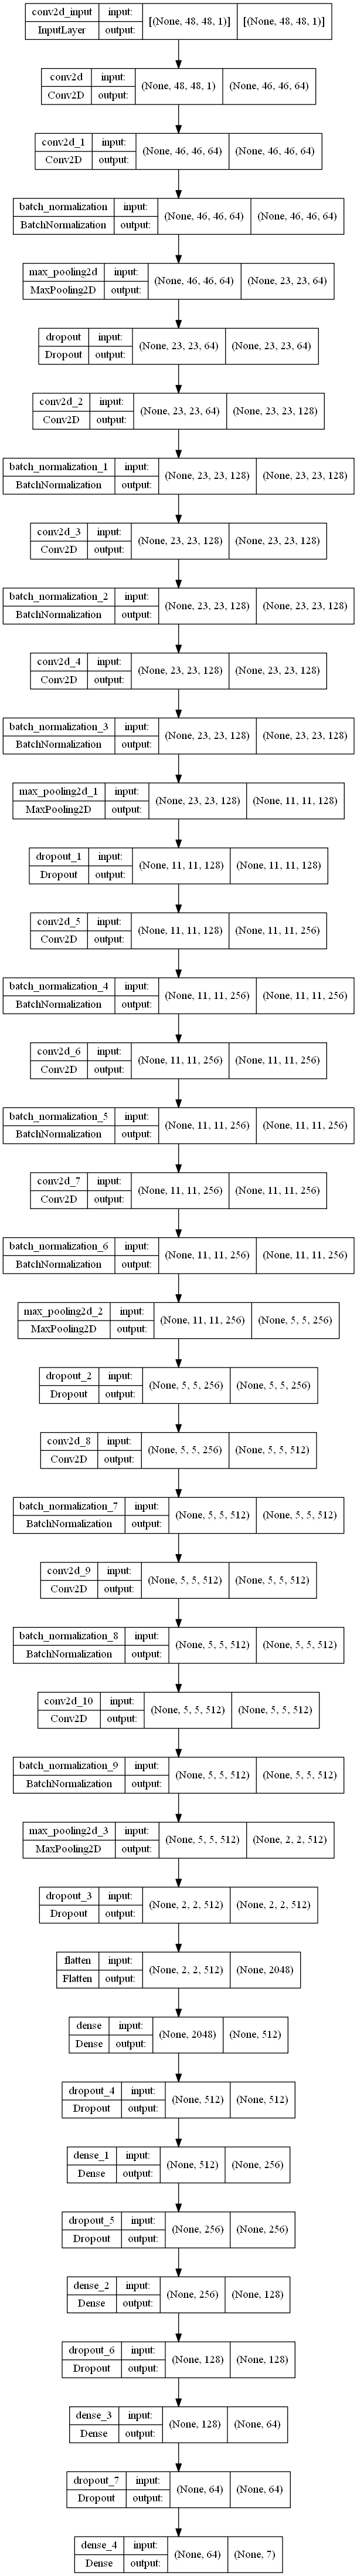

In [39]:
#  Visualization of Convolution Nueral Network
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)

### Define Callbacks

In [12]:
model_name = "best_model.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20, mode = 'auto')

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

### Train Model

In [13]:
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks= [early_stop, monitor, lr_schedule],
          validation_data=(X_val, Y_val),
          shuffle=True)

Epoch 1/100
449/449 [==============================] - 1169s 3s/step - loss: 2.0703 - accuracy: 0.1983 - val_loss: 1.8629 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 1268s 3s/step - loss: 1.8570 - accuracy: 0.2385 - val_loss: 1.8309 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 1186s 3s/step - loss: 1.8365 - accuracy: 0.2471 - val_loss: 1.8293 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 1159s 3s/step - loss: 1.8286 - accuracy: 0.2495 - val_loss: 1.8211 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 1196s 3s/step - loss: 1.8198 - accuracy: 0.2506 - val_loss: 1.8140 - val_accuracy: 0.2452 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 1144s 3s/step - loss: 1.7920 - accuracy: 0.2631 - val_loss: 1.7772 - val_accuracy: 0.2664 - lr: 0.0010
Epoch 7/100
449/449 [==============================]

### Test Model

In [14]:
# Testing Model on unseen data

from sklearn.metrics import accuracy_score

predicted_test_labels = np.argmax(model.predict(X_test), axis=1)
test_labels = np.argmax(Y_test, axis=1)
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))

Accuracy score =  0.6185567010309279


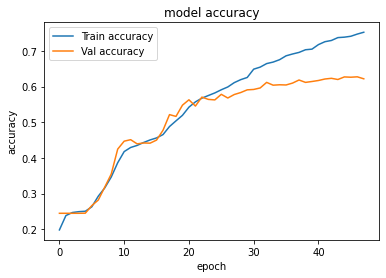

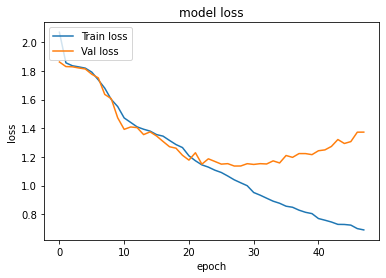

In [49]:
# History plot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Val accuracy'], loc='upper left')
plt.show()


# History plot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Val loss'], loc='upper left')
plt.show()

In [46]:
#GradCam

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        #class_channel = preds[:, 0]
        

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(256, 256))
    return heatmap_resized

ValueError: num must be 1 <= num <= 24, not 25

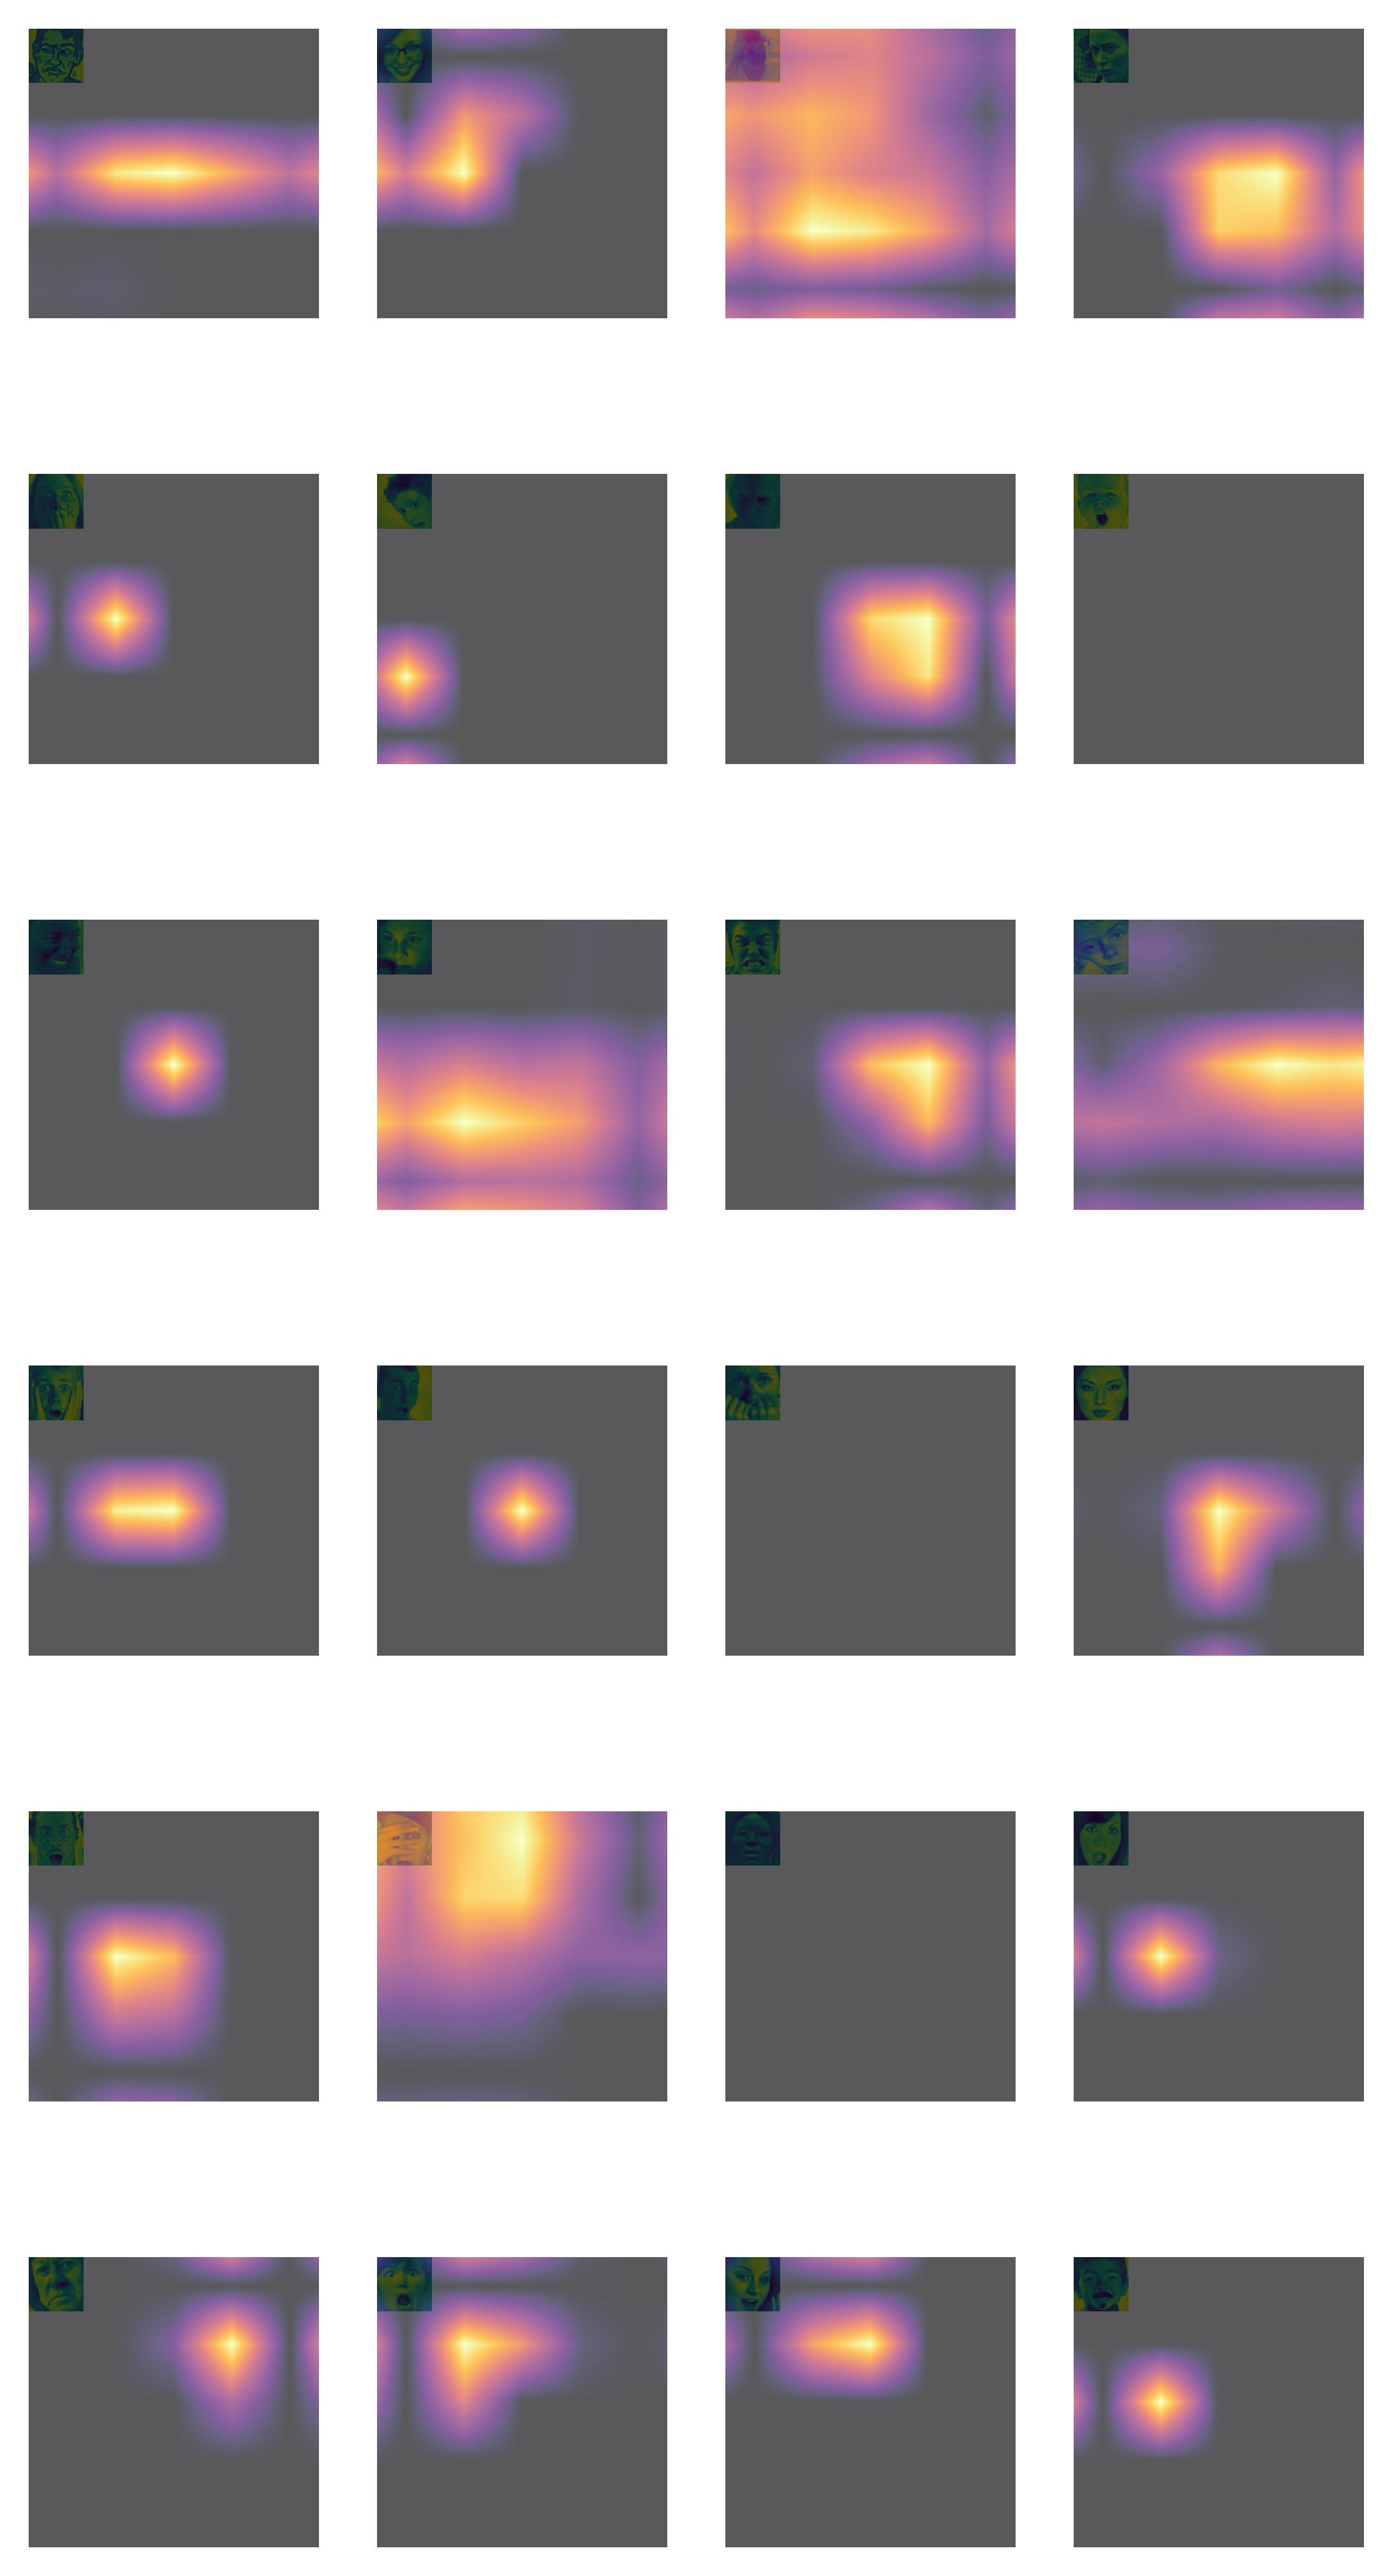

In [47]:
# Remove last layer's
model.layers[-1].activation = None

plt.figure(figsize = (6,12),dpi = 450)

for ii in range(X_test.shape[0]//4):
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(X_test[ii*4][np.newaxis,:,:,np.newaxis], model, "conv2d_10")
    plt.subplot(6,4,ii+1)
    plt.imshow(X_test[ii*4])
    plt.imshow(heatmap, alpha = 0.65, cmap = "inferno")
    #plt.colorbar()
    plt.axis("off")
plt.show()

In [22]:
#Saving the model to use it later in .json file to only cover the face area for recognition
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")
